Goal here is to create the descDitheredRA, descDitheredDec, descDitheredRotTelPos:
- All visits will have rotational dithers as in DC1: random between -90, 90 degrees; after every filter change.
- WFD visits will have translational visits as in DC1: random as large as 1.75 degree; after every visit.
- DDF visits will also have translational dithers: chip-scale; after every visit.

The idea is to append the three columns to the .db file where the first two will have the right translational dithers depending on whether the visits are DDF visits (chip-scale dithers) or WFD ones (large dithers).
- The large translational dithers and rotational dithers are from the afterburner output: minion_1016_sqlite_new_dithers.db
- For DDF dithers, running MAF Stacker for per visit translational dithers with the right 'amplitude' of the dithers.

#### Couldnt get sql to work so sent the columns to Rahul. He added the columns to the .db file and created minion_1016_desc_dithered_v3.db.

Some additional info:
- Input file: `minion_1016_sqlite_new_dithers.db` (filename in `dbfile` parameter name)
- Output file: `descDithers_attempt1.csv`
- DDF dithers have max amplitude of 0.11667 degrees (see info after Input [6] for details); the value is stored in the `chipMaxDither` parameter and is passed onto the `maxDither` input to the stacker in Input [9]. WFD translational dithers and rotational dithers were implemented by the updated afterburner for DC1.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [2]:
homeDir= '/Users/humnaawan'

# database from the new afterburner: has random rotDithers in ditheredRotTelPos to compare the stacker output.
dbfile = '%s/lsstData/minion_1016_sqlite_new_dithers.db'%homeDir

#### Read in the data: afterburner output: has 
- 'randomDitherFieldPerVisitRA', 'randomDitherFieldPerVisitDec': for WFD, DDFs: large dithers
- 'ditheredRotTelPos': rotational dithers



In [3]:
import lsst.sims.maf.db as db
opsdb = db.OpsimDatabase(dbfile)  #database

In [4]:
colnames = ['propID', 'fieldID', 'fieldRA', 'fieldDec', 
            'randomDitherFieldPerVisitRA', 'randomDitherFieldPerVisitDec',
           'ditheredRotTelPos', 'rotTelPos']

simdata_afterburner= opsdb.fetchMetricData(colnames= colnames, sqlconstraint= None)

In [5]:
simdata_afterburner

array([ (      1, 54,  316,  1.676483, -1.082473,  1.71553269, -1.086185,  0.      ,  0.      ),
       (      2, 54,  372,  1.69412 , -1.033972,  1.66340685, -1.059274,  0.002508,  0.002508),
       (      3, 54,  441,  1.708513, -0.985271,  1.68582904, -0.962342,  0.005246,  0.005246),
       ...,
       (2447929, 54, 1511,  3.578785, -0.447271,  3.57961904, -0.425568,  1.836622,  0.852225),
       (2447930, 54, 1612,  3.608418, -0.401322,  3.62496254, -0.387863,  1.836998,  0.852601),
       (2447931, 54, 1495,  3.633023, -0.451709,  3.6181503 , -0.461384,  1.837181,  0.852784)],
      dtype=(numpy.record, [('obsHistID', '<i8'), ('propID', '<i8'), ('fieldID', '<i8'), ('fieldRA', '<f8'), ('fieldDec', '<f8'), ('randomDitherFieldPerVisitRA', '<f8'), ('randomDitherFieldPerVisitDec', '<f8'), ('ditheredRotTelPos', '<f8'), ('rotTelPos', '<f8')]))

#### Add chip-scale dither column

In [6]:
import lsst.sims.maf.utils as mafUtils
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.stackers as stackers

15 chips along the diameter of a FOV

=> chipSize= 1.75*2/15

=> chipMaxDither= chipSize/2

In [7]:
chipSize= 1.75*2/15

chipMaxDither= chipSize/2
print(chipMaxDither)

0.11666666666666667


In [8]:
# set up to run the stacker.
metric = metrics.PassMetric()  # want to access the database; no analysis needed
slicer = slicers.OneDSlicer(sliceColName='night', binsize=1)   # essentially accessing all nights
sqlconstraint= None

In [9]:
stackerList = [stackers.RandomDitherFieldPerVisitStacker(maxDither= chipMaxDither )]

In [10]:
outDir = '%s/stackers_uDDF'%homeDir
resultsDb = db.ResultsDb(outDir=outDir)

# set up metric bundle
bundle = metricBundles.MetricBundle(metric, slicer, sqlconstraint= sqlconstraint, stackerList=stackerList)
bgroup = metricBundles.MetricBundleGroup({'check': bundle}, opsdb, outDir=outDir,
                                         resultsDb=resultsDb, saveEarly= False)
# run the bundle
bgroup.runAll()

Querying database with no constraint.
Found 2447931 visits
Running:  ['check']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [11]:
bgroup.simData

array([(      1,    0, -1.082473,  1.676483,  1.67505076, -1.08202454),
       (      2,    0, -1.033972,  1.69412 ,  1.69367123, -1.03320646),
       (      3,    0, -0.985271,  1.708513,  1.70849298, -0.98567924),
       ...,
       (2447929, 3649, -0.447271,  3.578785,  3.57753393, -0.44656881),
       (2447930, 3649, -0.401322,  3.608418,  3.60995224, -0.40218307),
       (2447931, 3649, -0.451709,  3.633023,  3.63162487, -0.45163034)],
      dtype=[('obsHistID', '<i8'), ('night', '<i8'), ('fieldDec', '<f8'), ('fieldRA', '<f8'), ('randomDitherFieldPerVisitRa', '<f8'), ('randomDitherFieldPerVisitDec', '<f8')])

#### Quick checks on the dithers.

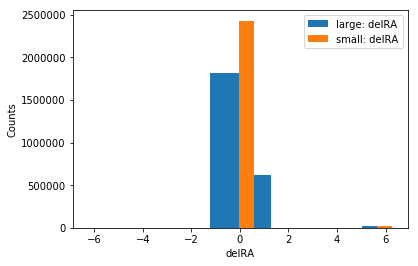

In [12]:
delRA_afterB= simdata_afterburner['randomDitherFieldPerVisitRA']-simdata_afterburner['fieldRA']     
plt.hist(delRA_afterB, label= 'large: delRA')
delRA_small= bgroup.simData['randomDitherFieldPerVisitRa']-bgroup.simData['fieldRA']
plt.hist(delRA_small, label= 'small: delRA')
plt.xlabel('delRA')
plt.ylabel('Counts')
plt.legend()

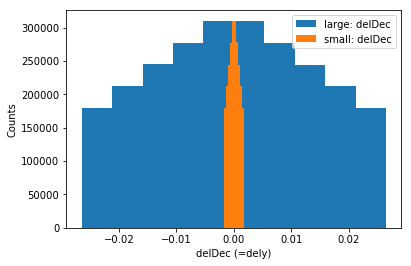

In [13]:
delDec_afterB= simdata_afterburner['randomDitherFieldPerVisitDec']-simdata_afterburner['fieldDec'] 
plt.hist(delDec_afterB, label= 'large: delDec')

delDec_small= bgroup.simData['randomDitherFieldPerVisitDec']-bgroup.simData['fieldDec']
plt.hist(delDec_small, label= 'small: delDec')
plt.xlabel('delDec (=dely)')
plt.ylabel('Counts')
plt.legend()

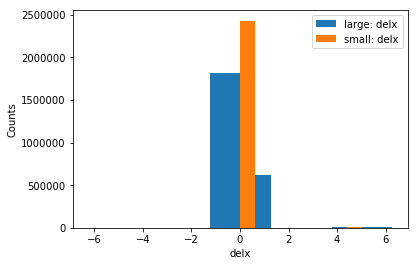

In [14]:
plt.hist(delRA_afterB*np.cos(simdata_afterburner['fieldDec']), label= 'large: delx')
plt.hist(delRA_small*np.cos(bgroup.simData['fieldDec']), label= 'small: delx')
plt.xlabel('delx')
plt.ylabel('Counts')
plt.legend()

##### Things look ok. The dithers far away frrom the origin are due to RA wrapping in the Stacker; they seem to be close ot 2pi.

#### Combine the dithers with the .db file. First create arrays with for descDitheredRA, descDitheredDec, descDitheredRotTelPos

In [15]:
#### Figure out the propID to distinguish WFD, DDFs
import lsst.sims.maf.utils as mafUtils
propIds, propTags = opsdb.fetchPropInfo()
print(propIds)
print(propTags)

{52: 'GalacticPlane', 53: 'SouthCelestialPole-18', 54: 'Universal-18-0824B', 55: 'NorthEclipticSpur-18c', 56: 'DDcosmology1'}
{'WFD': [54], 'DD': [56]}


In [16]:
tot= len(simdata_afterburner)
print('Total visits: ', tot)

Total visits:  2447931


In [17]:
descDitheredRotTelPos= simdata_afterburner['ditheredRotTelPos'].copy()

# initiate as undithered poinitngs as nonWFD, nonDDF should remain unchanged
descDitheredRA= simdata_afterburner['fieldRA'].copy()
descDitheredDec= simdata_afterburner['fieldDec'].copy()

In [18]:
# add WFD dithers
ind_WFD= np.where(simdata_afterburner['propID']== propTags['WFD'])[0]
print('%s WFD visits out of total %s'%(len(ind_WFD), tot))

descDitheredRA[ind_WFD]= simdata_afterburner['randomDitherFieldPerVisitRA'][ind_WFD]
descDitheredDec[ind_WFD]= simdata_afterburner['randomDitherFieldPerVisitDec'][ind_WFD]

2083758 WFD visits out of total 2447931


In [19]:
# add DDF dithers
ind_DD= np.where(simdata_afterburner['propID']== propTags['DD'])[0]
print('%s DD visits out of total %s'%(len(ind_DD), tot))

descDitheredRA[ind_DD]= bgroup.simData['randomDitherFieldPerVisitRa'][ind_DD]
descDitheredDec[ind_DD]= bgroup.simData['randomDitherFieldPerVisitDec'][ind_DD]

111121 DD visits out of total 2447931


In [20]:
# check
print('WFD obsIDs match: ', np.unique(simdata_afterburner['obsHistID'][ind_WFD]==bgroup.simData['obsHistID'][ind_WFD]))
print('DD obsIDs match: ', np.unique(simdata_afterburner['obsHistID'][ind_DD]==bgroup.simData['obsHistID'][ind_DD]))

WFD obsIDs match:  [ True]
DD obsIDs match:  [ True]


Things look ok.

#### Run sql to add the columns.

Couldnt get c.executemany to add the values and c.execute seems to take forever.

Rahul Biswas has the code to add the columns so decided to send the new columns to him.

In [21]:
import pandas as pd
# save the columns as a csv file for Rahul.
d= {'obsHistID': simdata_afterburner['obsHistID'], 
    'descDitheredRA': descDitheredRA, 'descDitheredDec': descDitheredDec, 
    'descDitheredRotTelPos': simdata_afterburner['ditheredRotTelPos']}
DF= pd.DataFrame(d)

os.chdir(outDir)
out= DF.to_csv('descDithers_attempt1.csv')